# Task 2: Image Classification with CNNs (50%)

In this task, you'll dive into the world of Convolutional Neural Networks (CNNs) by working with the CIFAR-10 dataset, a staple in image classification challenges. Your goal is to build and evaluate two different CNN models to classify images into one of the ten categories accurately.

The dataset is availabel in pytorch and keras.

## Part 1: Custom CNN Model (20%)

- Design and train a CNN model from scratch tailored for the CIFAR-10 dataset.
- Focus on the architecture that you believe will perform best for this specific task.
- Integrate various techniques such as batch normalization, dropout, learning rate schedulers, and early stopping to improve model training. Experiment with these methods and finetune them to see how they affect training stability, convergence speed, and overall performance.

## Part 2: Transfer Learning Model (20%)

- Implement a transfer learning approach using a pre-trained model of your choice.
- Fine-tune the model on the CIFAR-10 dataset to achieve the best possible performance.

## Evaluation (10%)

Ensure that both models are robust and generalized well to unseen data.

After training both models, you will evaluate them on a provided test dataset.

Compare your models based on:
- **AUC-ROC**: How well does each model discriminate between classes?
- **Model Size**: Consider the trade-offs in model complexity.
- **Inference Speed**: Evaluate how quickly your model can predict classes for new images.

Reflect on the performance, size, and inference speed of both models. What insights can you draw from these comparisons?

### Learning Objectives

- Understand and apply CNNs for image classification.
- Explore the impact of model architecture on performance and efficiency.
- Learn the process and benefits of transfer learning in deep learning.

Remember, the key to this task is not just about achieving the highest accuracy but also understanding the strengths and limitations of different approaches in machine learning model development.

# Custom CNN Model

In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import datasets
import tensorflow as tf

In [2]:
# check version of tensorflow
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.1


In [3]:

# Load the CIFAR-10 dataset
(x_train, y_train), (x_val, y_val) = datasets.cifar10.load_data()

# load dataset from task_2_test_images.npy and task_2_test_labels.npy
x_test = np.load('task_2_test_images.npy')
y_test = np.load('task_2_test_labels.npy')


# Normalize the pixel values
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# One-hot encode the labels
y_train = np.eye(10)[y_train.reshape(-1)]
y_val = np.eye(10)[y_val.reshape(-1)]
y_test = np.eye(10)[y_test.reshape(-1)]

# Print the shape of the datasets
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)



(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)
(9956, 32, 32, 3) (9956, 10)


In [4]:
# create the dataset and dataloader
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


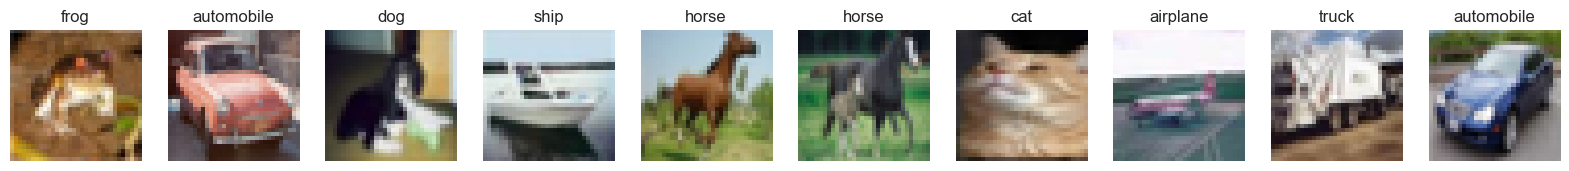

In [5]:
plt.figure(figsize=(20, 20))

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, (img, label) in enumerate(train_dataset.take(10)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img[0])
    plt.title(labels[np.argmax(label[0])])
    plt.axis('off')

# Data Augmentation

In [6]:
# augment the training set

IMG_SIZE = 32

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip(),
  layers.RandomRotation(factor=0.1),
  layers.RandomZoom(height_factor=-0.1, width_factor=-0.1),
  layers.RandomContrast(factor=0.1),
])


gaussian_noise = tf.keras.Sequential([
  layers.GaussianNoise(0.1)
])


In [7]:
def random_gaussian_noise(x):
    probability = 0.1
    if np.random.rand() < probability:
        return gaussian_noise(x, training=True)
    else:
        return x
    
def random_cutout(x, probability=0.2):
    # randomly choose 5 to 20 pixels (not one part, but several separate pixels) on the image and put them to random color
    if np.random.rand() < probability:
        mask = np.ones((IMG_SIZE, IMG_SIZE, 3))
        for _ in range(np.random.randint(5, 20)):
            x_pos = np.random.randint(0, IMG_SIZE)
            y_pos = np.random.randint(0, IMG_SIZE)
            mask[x_pos, y_pos] = np.random.randint(0, 256, 3) / 255
        return x * mask
    else:
        return x

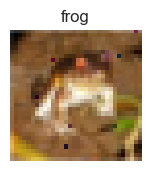

In [8]:
# take the first image from the training dataset and apply data augmentation
plt.figure(figsize=(20, 20))

for i, (img, label) in enumerate(train_dataset.take(1)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(random_cutout(img, 1)[0])
    plt.title(labels[np.argmax(label[0])])
    plt.axis('off')

In [9]:
train_dataset_aug = train_dataset.map(lambda x, y: (random_gaussian_noise(x), y))
train_dataset_aug = train_dataset_aug.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset_aug = train_dataset_aug.map(lambda x, y: (random_cutout(x), y))

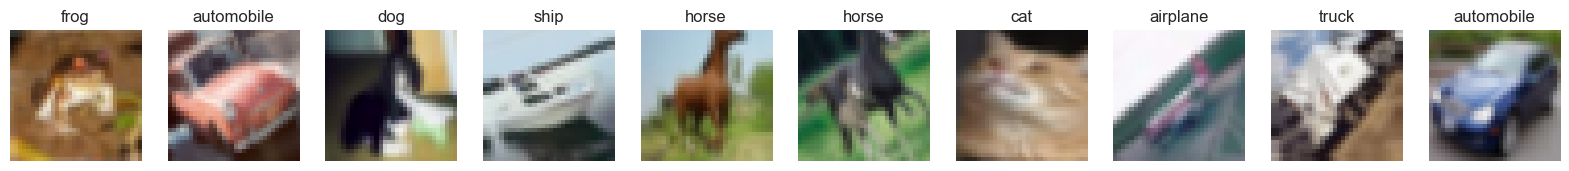

In [10]:
plt.figure(figsize=(20, 20))

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, (img, label) in enumerate(train_dataset_aug.take(10)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img[0])
    plt.title(labels[np.argmax(label[0])])
    plt.axis('off')

In [11]:
# model architecture idea was inspired by: https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer
model = models.Sequential([
    # data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 15, 15, 32)       128       
 hNormalization)                                                 
                                                      

In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
t = time.time()
history = model.fit(train_dataset_aug, epochs=25, validation_data=val_dataset)
print(f'Time taken: {time.time() - t:.2f} seconds')

Epoch 1/25
782/782 [==============================] - 69s 81ms/step - loss: 1.7141 - accuracy: 0.4098 - val_loss: 1.5126 - val_accuracy: 0.5050
Epoch 2/25
782/782 [==============================] - 60s 77ms/step - loss: 1.3685 - accuracy: 0.5114 - val_loss: 1.2664 - val_accuracy: 0.5618
Epoch 3/25
782/782 [==============================] - 60s 77ms/step - loss: 1.2248 - accuracy: 0.5686 - val_loss: 1.0699 - val_accuracy: 0.6244
Epoch 4/25
782/782 [==============================] - 63s 80ms/step - loss: 1.1316 - accuracy: 0.6050 - val_loss: 1.1546 - val_accuracy: 0.6103
Epoch 5/25
782/782 [==============================] - 63s 80ms/step - loss: 1.0726 - accuracy: 0.6225 - val_loss: 1.1308 - val_accuracy: 0.6290
Epoch 6/25
782/782 [==============================] - 62s 80ms/step - loss: 1.0120 - accuracy: 0.6467 - val_loss: 1.1767 - val_accuracy: 0.6309
Epoch 7/25
782/782 [==============================] - 59s 75ms/step - loss: 0.9683 - accuracy: 0.6628 - val_loss: 0.9430 - val_accuracy:

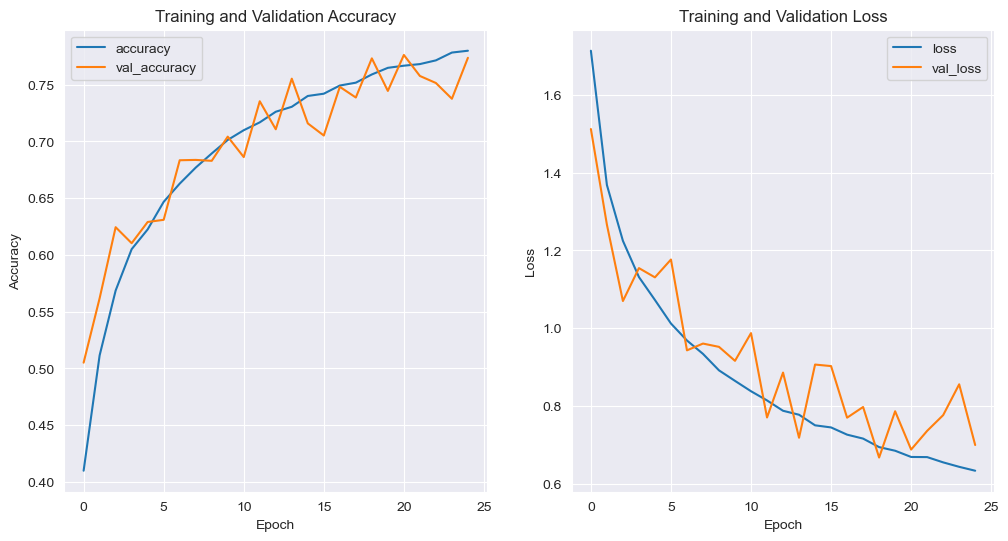

In [14]:
# Plot the training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
    
plt.show()


In [15]:
# evaluate the model on the test dataset
from sklearn.metrics import roc_auc_score

# unpack the test_dataset
y_test = np.concatenate([y for x, y in test_dataset], axis=0)
x_test = np.concatenate([x for x, y in test_dataset], axis=0)

In [16]:
# evaluate the model on the test set with accuracy and AUC-ROC
from sklearn.metrics import roc_auc_score

y_pred = model.predict(x_test)
y_true = y_test

accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
auc_roc = roc_auc_score(y_true, y_pred, multi_class='ovr')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test AUC-ROC: {auc_roc:.4f}')
# draw the ROC curve
from sklearn.metrics import roc_curve

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_pred[:, i])
    

312/312 [==============================] - 1s 2ms/step
Test Accuracy: 0.6337
Test AUC-ROC: 0.9335


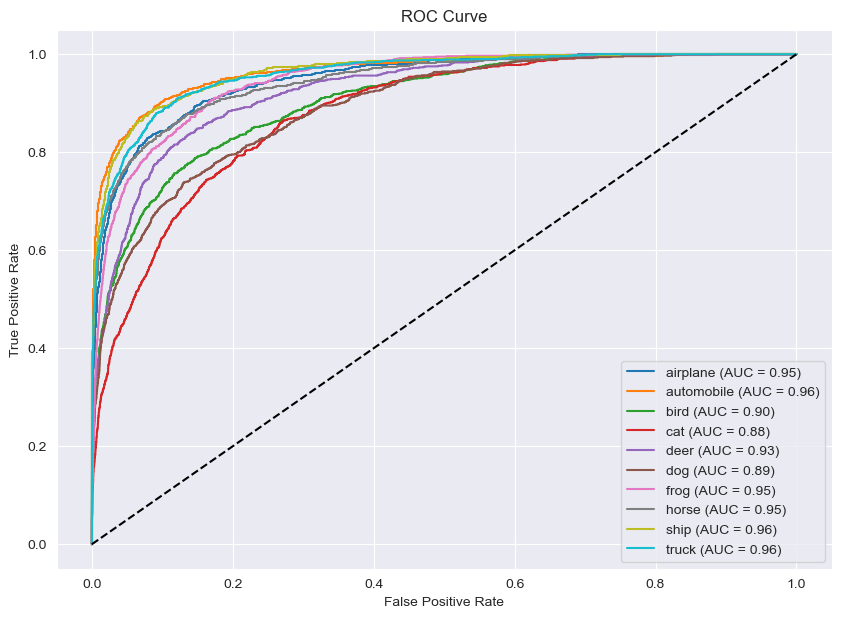

In [17]:
plt.figure(figsize=(10, 7))

for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Part 2: Transfer Learning Model
Idea for the model and the transfer of learning approach was inspired by: https://www.kaggle.com/code/phoebewongtw/transfer-learning-with-xception-for-cifar-10
Useful information and code snippets were found on: https://keras.io/guides/transfer_learning/ 

### Use "raw" Xception on the test data

In [18]:
import numpy as np
import time

import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications
import tensorflow as tf

The data is already loaded and preprocessed in the previous section. We will use the same data for the transfer learning model.

In [19]:
y_train = np.concatenate([y for x, y in train_dataset], axis=0)
x_train = np.concatenate([x for x, y in train_dataset], axis=0)

y_val = np.concatenate([y for x, y in val_dataset], axis=0)
x_val = np.concatenate([x for x, y in val_dataset], axis=0)

In [20]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
resized = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (71, 71)))(inputs)

Tensors need to be resized to at least to 71x71 be compatible with the Xception model.

In [21]:
base_model = applications.Xception(include_top=False, weights='imagenet', input_tensor=resized, input_shape=None)

base_model.trainable = False
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 71, 71, 3)    0           ['input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['lambda[0][0]']                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                    

In [22]:
x = applications.mobilenet.preprocess_input(base_model.output)
x = layers.Flatten()(x)
x = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 71, 71, 3)    0           ['input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['lambda[0][0]']                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                       

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

There is no improvement since, the model training mode is disabled, just to show that simply the pretrained model will not adapt to our new data.

In [24]:
epochs = 5
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=128)

Epoch 1/5
391/391 [==============================] - 15s 32ms/step - loss: 5.4676 - accuracy: 0.1024 - val_loss: 7.6924 - val_accuracy: 0.1000
Epoch 2/5
391/391 [==============================] - 12s 30ms/step - loss: 5.2180 - accuracy: 0.0995 - val_loss: 2.7177 - val_accuracy: 0.1299
Epoch 3/5
391/391 [==============================] - 12s 31ms/step - loss: 5.4389 - accuracy: 0.1008 - val_loss: 4.7708 - val_accuracy: 0.1000
Epoch 4/5
391/391 [==============================] - 12s 31ms/step - loss: 4.0151 - accuracy: 0.1040 - val_loss: 8.5036 - val_accuracy: 0.1000
Epoch 5/5
391/391 [==============================] - 12s 31ms/step - loss: 4.5174 - accuracy: 0.0999 - val_loss: 3.1048 - val_accuracy: 0.1000


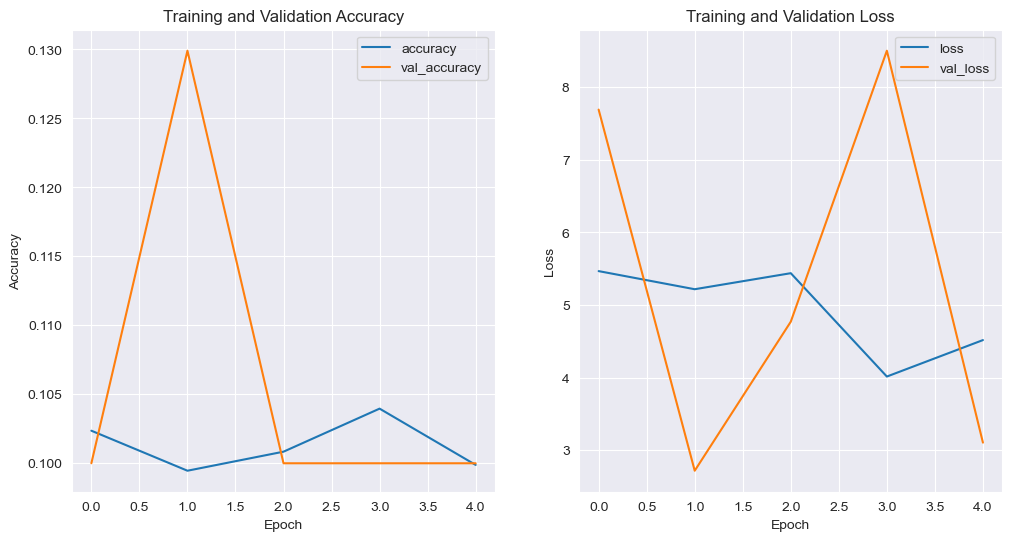

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
    
plt.show()

In [26]:
# test accuracy
from sklearn.metrics import roc_auc_score

y_pred = model.predict(x_test)
y_true = y_test

accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
auc_roc = roc_auc_score(y_true, y_pred, multi_class='ovr')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test AUC-ROC: {auc_roc:.4f}')
from sklearn.metrics import roc_curve

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_pred[:, i])

312/312 [==============================] - 3s 9ms/step
Test Accuracy: 0.0988
Test AUC-ROC: 0.7917


Without training, Xception model does not show good results "out of the box". The model needs to be trained on the CIFAR-10 dataset.

### Fine tuning Xception on the train dataset

In [27]:
base_model.trainable = True

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 15
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=128)

Epoch 1/15
391/391 [==============================] - 47s 111ms/step - loss: 5.7419 - accuracy: 0.1814 - val_loss: 2.0136 - val_accuracy: 0.3432
Epoch 2/15
391/391 [==============================] - 44s 113ms/step - loss: 2.5995 - accuracy: 0.3649 - val_loss: 4.6415 - val_accuracy: 0.3759
Epoch 3/15
391/391 [==============================] - 45s 115ms/step - loss: 1.5046 - accuracy: 0.7194 - val_loss: 0.8379 - val_accuracy: 0.8346
Epoch 4/15
391/391 [==============================] - 45s 116ms/step - loss: 0.4664 - accuracy: 0.9248 - val_loss: 0.6117 - val_accuracy: 0.8532
Epoch 5/15
391/391 [==============================] - 46s 117ms/step - loss: 0.2843 - accuracy: 0.9510 - val_loss: 0.4827 - val_accuracy: 0.8810
Epoch 6/15
391/391 [==============================] - 45s 116ms/step - loss: 0.2003 - accuracy: 0.9616 - val_loss: 0.9412 - val_accuracy: 0.8331
Epoch 7/15
391/391 [==============================] - 45s 116ms/step - loss: 0.1416 - accuracy: 0.9723 - val_loss: 0.4554 - val_ac

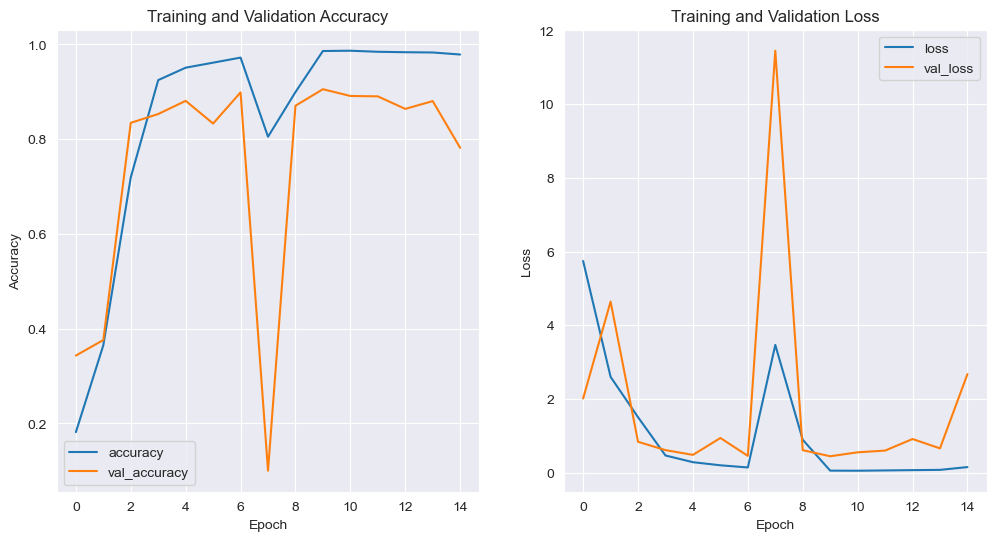

In [28]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
    
plt.show()

In [29]:
# test accuracy
from sklearn.metrics import roc_auc_score

y_pred = model.predict(x_test)
y_true = y_test

accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
auc_roc = roc_auc_score(y_true, y_pred, multi_class='ovr')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test AUC-ROC: {auc_roc:.4f}')
# draw the ROC curve
from sklearn.metrics import roc_curve

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_pred[:, i])

312/312 [==============================] - 4s 9ms/step
Test Accuracy: 0.6470
Test AUC-ROC: 0.9420


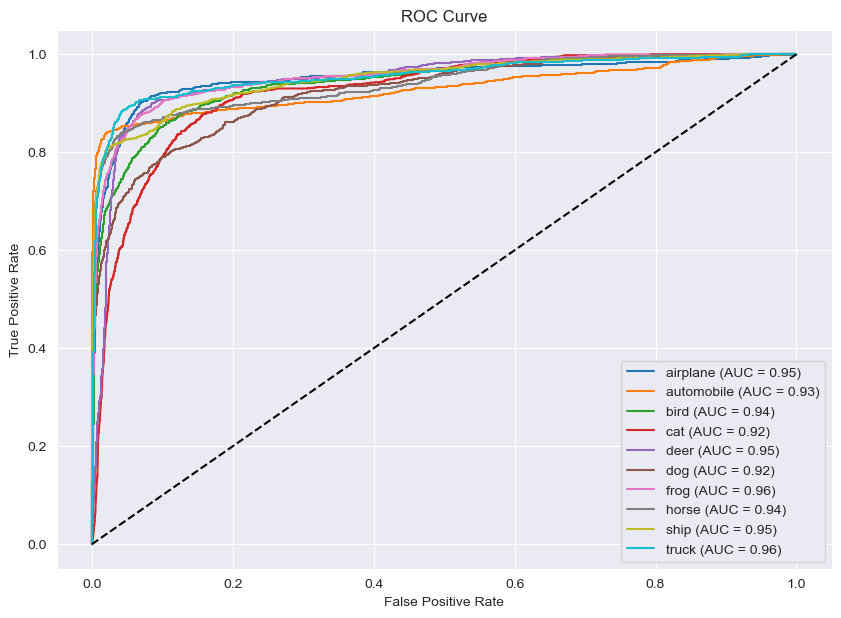

In [30]:
# draw auc-roc curve
plt.figure(figsize=(10, 7))

for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Summarizing the results

1) AUC-ROC:
- CNN: 
Test Accuracy: 0.6337
Test AUC-ROC: 0.9335

- Xception:
Test Accuracy: 0.6470
Test AUC-ROC: 0.9420

The Xception model has a slightly higher test accuracy and AUC-ROC compared to the custom CNN model. This can indicate a slightly better learning by the model of the dataset patterns.

2) Model Size:
- CNN:
Total params: 1,251,626
Trainable params: 1,251,242
Non-trainable params: 384

- Xception:
Total params: 21,045,810
Trainable params: 184,330
Non-trainable params: 20,861,480

The custom CNN model has a smaller overall size compared to the Xception model. The Xception model is significantly larger due to the complexity of the model architecture and the number of parameters in the pre-trained Xception model. CNN model still has more number of trainable parameters compared to Xception model. That might be the main reason, why CNN model requires significantly more training time and epoches.

3) Inference speed:
We can check the inference speed while predicting the class for new images , for example for the test dataset. The inference speed of the custom CNN model is faster compared to the Xception model in about 4 times (1s vs. 4s for the whole test dataset). This is because the custom CNN model is smaller and less complex, making it more efficient in making predictions.


Overall, both models perform well on the CIFAR-10 dataset, with the Xception model having a slight edge in terms of accuracy. However, the custom CNN model is more efficient in terms of model size and inference speed. The choice between the two models would depend on the specific requirements of the application, such as the need for accuracy, model size, and inference speed.